# Import Dependencies

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# Load the Dataset

In [43]:
os.chdir('C:\\Users\\ASUS\\Desktop\\ai\\Sign-Language-Digits-Dataset\\')

In [44]:
print(os.getcwd())

C:\Users\ASUS\Desktop\ai\Sign-Language-Digits-Dataset


# Split Data Train, Test, Validation

In [45]:
#  ORganize data into train, valid, test
os.chdir('Data/')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0,10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')


In [46]:
print(os.getcwd())

C:\Users\ASUS\Desktop\ai\Sign-Language-Digits-Dataset\Data


In [47]:
# Select path for each train, valid, test data
train_path = 'train/'
valid_path = 'valid/'
test_path = 'test/'

# Preprocess the images

In [48]:
# Preprocessing the data 
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,target_size=(224, 224), batch_size=10) 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path,target_size=(224, 224), batch_size=10) 
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,target_size=(224, 224), batch_size=10, shuffle=False) 

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Import the Base Model

In this step we freeze first 23 layer and add Dence layer with 10 nuroans.we use 10 nuroans because we have 10 classes (0,1,2,3,4,5,6,7,8,9) 

In [49]:
# Import the base model
mobile = tf.keras.applications.mobilenet.MobileNet()

In [50]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [59]:
x = mobile.layers[-6].output

In [61]:
x = tf.keras.layers.Flatten()(x)

In [62]:
output = Dense(units=10, activation='softmax')(x)

In [63]:
model = Model(inputs=mobile.input, outputs=output)

In [64]:
# Freze layers that are not train
for layer in model.layers[:-23]:
    layer.trainable = False

In [55]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

# Train the Model

In [65]:
# Train the Model 
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [67]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
172/172 - 33s - loss: 0.0855 - accuracy: 0.9848 - val_loss: 0.3539 - val_accuracy: 0.9533 - 33s/epoch - 194ms/step
Epoch 2/30
172/172 - 34s - loss: 0.0900 - accuracy: 0.9813 - val_loss: 0.2861 - val_accuracy: 0.9600 - 34s/epoch - 198ms/step
Epoch 3/30
172/172 - 33s - loss: 0.0409 - accuracy: 0.9912 - val_loss: 0.2564 - val_accuracy: 0.9667 - 33s/epoch - 194ms/step
Epoch 4/30
172/172 - 32s - loss: 0.0381 - accuracy: 0.9942 - val_loss: 0.2575 - val_accuracy: 0.9667 - 32s/epoch - 188ms/step
Epoch 5/30
172/172 - 33s - loss: 4.8993e-04 - accuracy: 1.0000 - val_loss: 0.2187 - val_accuracy: 0.9733 - 33s/epoch - 191ms/step
Epoch 6/30
172/172 - 32s - loss: 0.0471 - accuracy: 0.9930 - val_loss: 0.4636 - val_accuracy: 0.9467 - 32s/epoch - 189ms/step
Epoch 7/30
172/172 - 32s - loss: 0.1743 - accuracy: 0.9825 - val_loss: 0.5691 - val_accuracy: 0.9233 - 32s/epoch - 188ms/step
Epoch 8/30
172/172 - 32s - loss: 0.1177 - accuracy: 0.9895 - val_loss: 0.1418 - val_accuracy: 0.9767 - 32s/epoch -

# Predit Digits using trained model

In [68]:
#predit Sign Language Digits
test_labels = test_batches.classes

In [69]:
predictions = model.predict(x=test_batches, verbose=0)

# Visualize the Results

In [70]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [71]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [72]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


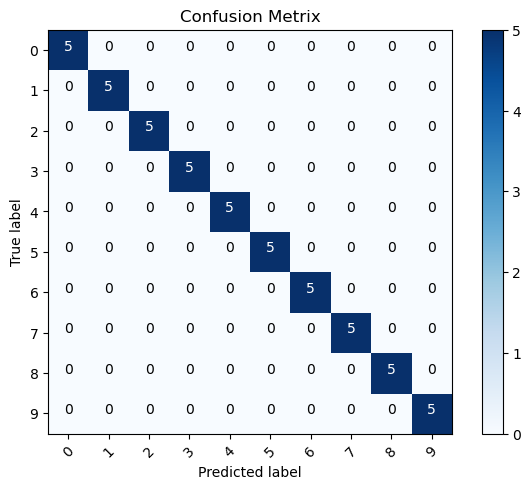

In [73]:
#plot the Confusion Metrix
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7','8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Metrix")

# Save the model

In [74]:
# Save the Model
model.save('Sign-Language-Digits-Classification-Model')

INFO:tensorflow:Assets written to: Sign-Language-Digits-Classification-Model\assets


INFO:tensorflow:Assets written to: Sign-Language-Digits-Classification-Model\assets
